#  Masking Pipeline

In [2]:
from chxanalys.chx_libs import np, roi, time, datetime, os,  getpass, db, get_images,LogNorm, plt,ManualMask

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,load_data, 
                                             RemoveHot, show_img, get_avg_img, reverse_updown)
 
%matplotlib notebook

In [3]:
from chxtools.handlers import LazyEigerHandler

db.fs.register_handler('AD_EIGER', LazyEigerHandler)

In [4]:
#LazyEigerHandler??

# Path for Saving Results

In [5]:
path = '/XF11ID/analysis/2016_3/masks/'
print ("The analysis results will be saved in : %s"%path)



The analysis results will be saved in : /XF11ID/analysis/2016_3/masks/


### Get the image series and metadata from the uid

In [6]:
uid = 'a3e323'

In [7]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  2626--a3e323b4-d2aa-428f-8a1d-5d87b4fa30f1--/XF11ID/data/2016/10/11/b0aadcff-7922-4559-bda6_584


In [8]:
#imgs = load_data( uid, detector, reverse= True  )
imgs = load_data( uid, detector, reverse= False  )
md = imgs.md

hdf5 path = /XF11ID/data/2016/10/11/b0aadcff-7922-4559-bda6_584_master.h5


In [9]:
imgs

<Frames>
Length: 18000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32

In [10]:
Nimg=len(imgs)

In [11]:
 md['pixel_mask'] =  1- np.int_( np.array( md['pixel_mask'], dtype= bool)  )

## show image and the pixel mask

<IPython.core.display.Javascript object>


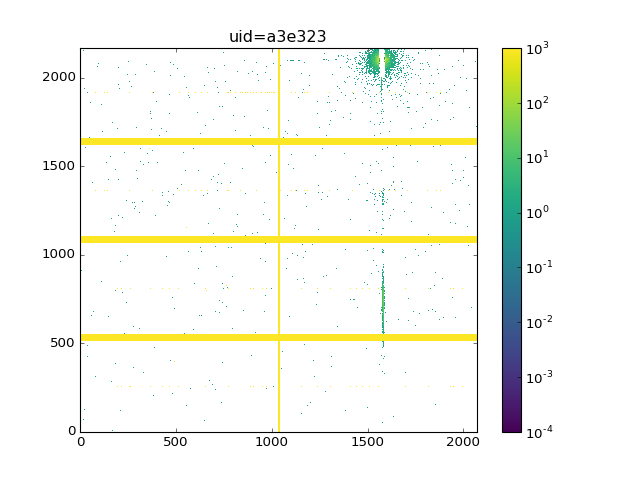

In [12]:
show_img(  imgs[0] , vmin=.0001, vmax=1000, logs=True, image_name ='uid=%s'%uid )





<IPython.core.display.Javascript object>


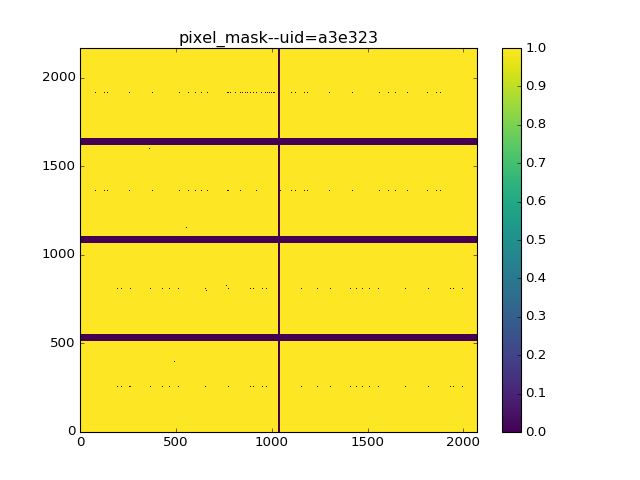

In [13]:
show_img(md['pixel_mask'], vmin=0, vmax=1, image_name ='pixel_mask--uid=%s'%uid )

## Remove hotspots in the image

In [14]:
imgs.shape

(2167, 2070)

In [15]:
2167 - 799

1368

<IPython.core.display.Javascript object>


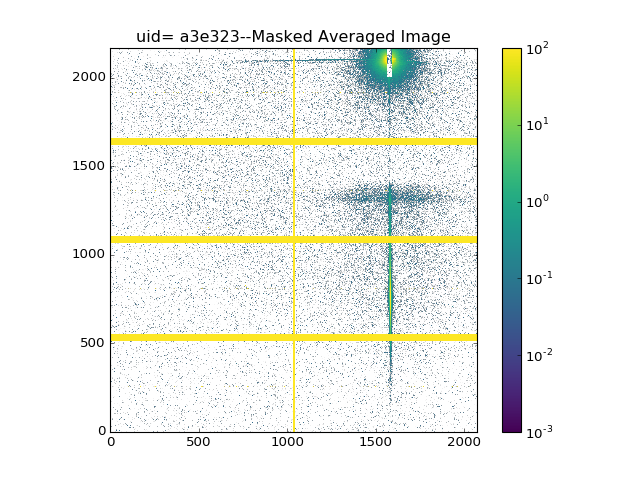

In [16]:
avg_img =  get_avg_img( imgs, sampling = 1000, plot_ = True, uid =uid)

<IPython.core.display.Javascript object>


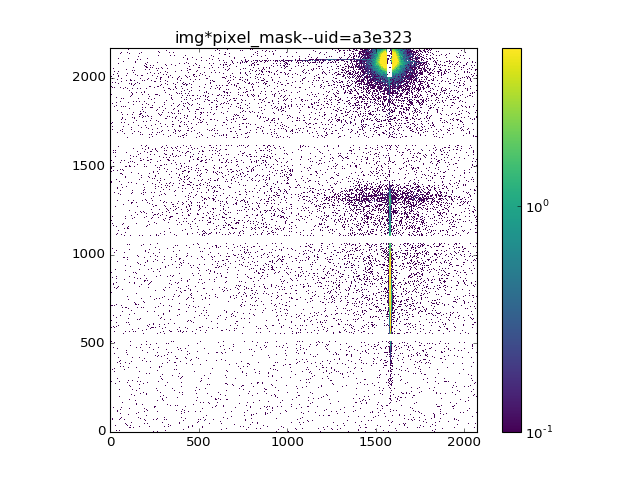

In [17]:
show_img(  avg_img*md['pixel_mask'],   vmin= .1, vmax= 5,
         logs= True, aspect=1.,image_name ='img*pixel_mask--uid=%s'%uid )

In [18]:
avg_img.shape

(2167, 2070)

<IPython.core.display.Javascript object>


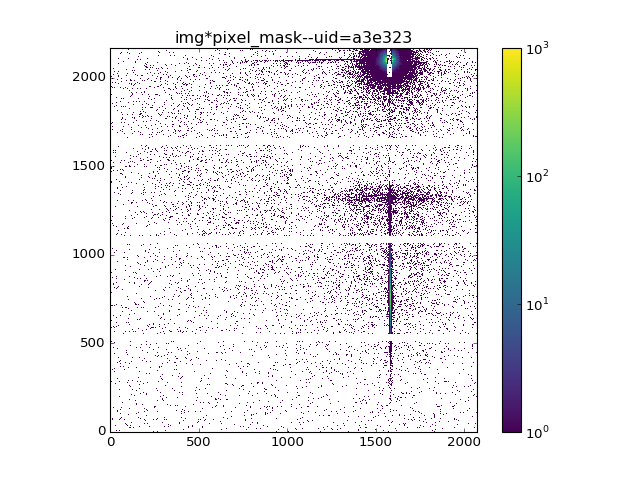

In [19]:
show_img(  avg_img*md['pixel_mask'],   vmin= 1, vmax= 1000,  aspect=1.,
         
         logs= True, image_name ='img*pixel_mask--uid=%s'%uid )

<IPython.core.display.Javascript object>


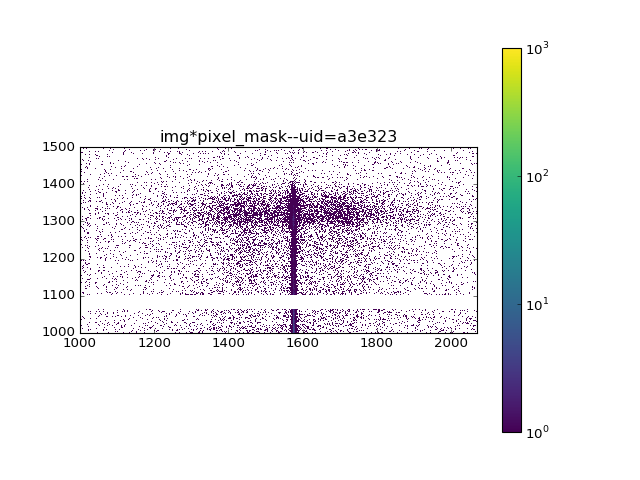

In [20]:
show_img(  avg_img*md['pixel_mask'],   vmin= 1, vmax= 1000, xlim=[1000, 2070], ylim=[1000, 1500], aspect=1.,
         
         logs= True, image_name ='img*pixel_mask--uid=%s'%uid )

In [21]:
avg_img.shape

(2167, 2070)

<IPython.core.display.Javascript object>


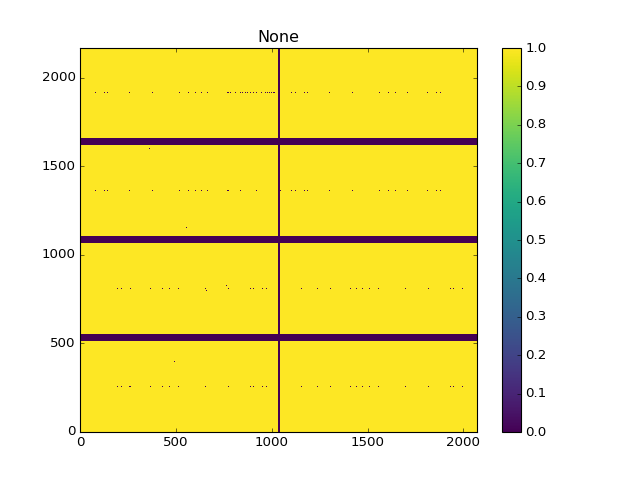

In [22]:
mask_rh  = RemoveHot( avg_img, 5E4, plot_=True)

## Manually create the mask file

<IPython.core.display.Javascript object>


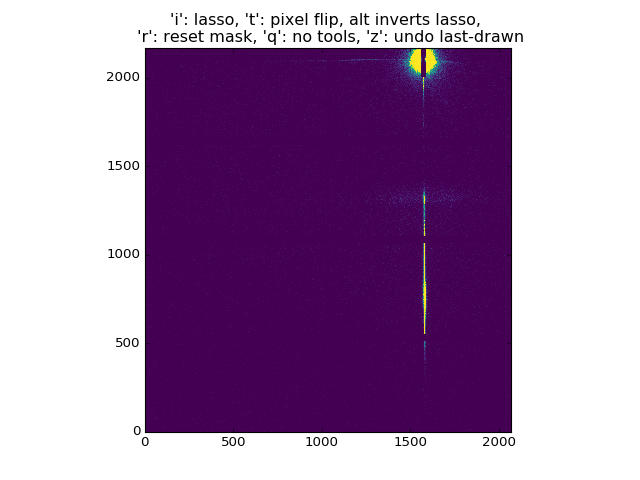

In [32]:
fig, ax = plt.subplots()
m = ManualMask(ax, avg_img* md['pixel_mask']*mask_rh,
               cmap='viridis',origin='lower',
               vmin=.01, vmax=1.50) 
plt.show()

<IPython.core.display.Javascript object>


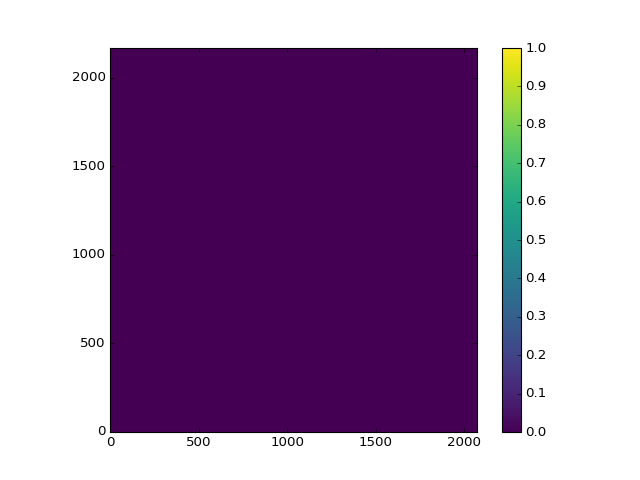

In [33]:
new_mask = m.mask
manu_mask  = new_mask.copy()
fig, ax = plt.subplots()
im=ax.imshow(new_mask,origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

In [34]:
manu_mask  = new_mask.copy()

# Create a polygon mask

In [24]:
from skimage.draw import line_aa, line, polygon

In [28]:
imgs.shape

(2167, 2070)

### To create multi-rectangle masks, for each sub-mask,
* Make x= the coordinate-x of the four cornners (pay attention to the reserve image-xy to python-xy )
* Make y= the coordinate-y of the four cornners 

In [45]:
#center of beam stop
bst_mask = np.zeros_like( avg_img , dtype = bool)
#x = np.array( [ 1555, 1588, 1588, 1555])  
#y = np.array( [ 1995, 1995, 2167, 2167])

x = np.array( [ 0, 2070, 2070, 0])  
y = np.array( [ 1950, 1950, 2167, 2167])

rr, cc = polygon( y,x)
bst_mask[rr,cc] =1



full_mask=~bst_mask  

<IPython.core.display.Javascript object>


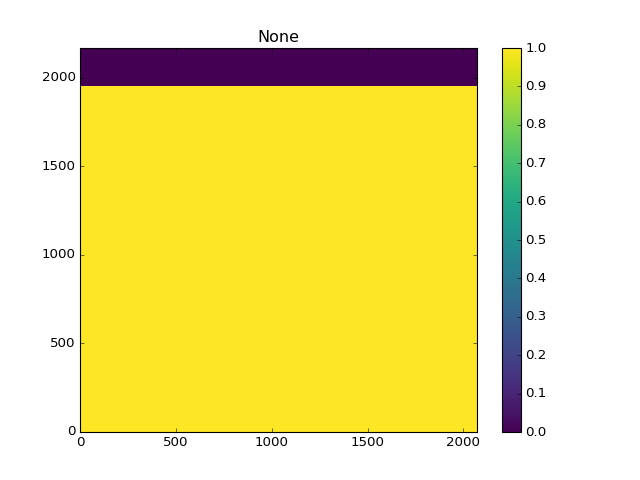

In [46]:
show_img(full_mask)

In [47]:
mask = np.array ( full_mask * md['pixel_mask']*mask_rh *~manu_mask , dtype = bool )

<IPython.core.display.Javascript object>


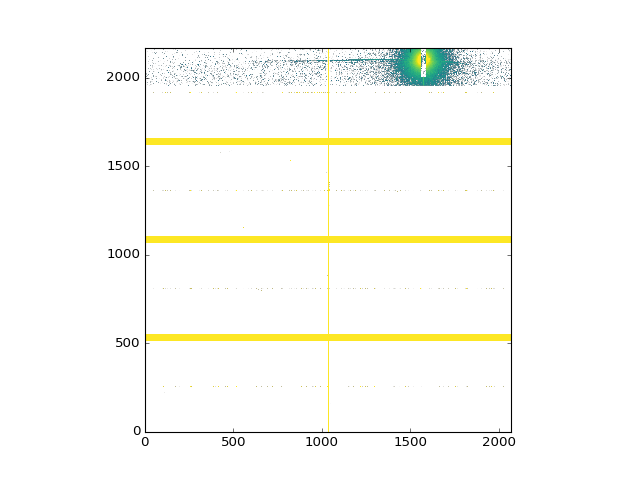

In [48]:
fig, ax = plt.subplots()
#new_mask = 
im=ax.imshow(   (~mask) * avg_img,origin='lower' , 
      norm= LogNorm( vmin=0.001, vmax=30 ), cmap='viridis')
#im = ax.imshow(avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
plt.show()


<IPython.core.display.Javascript object>


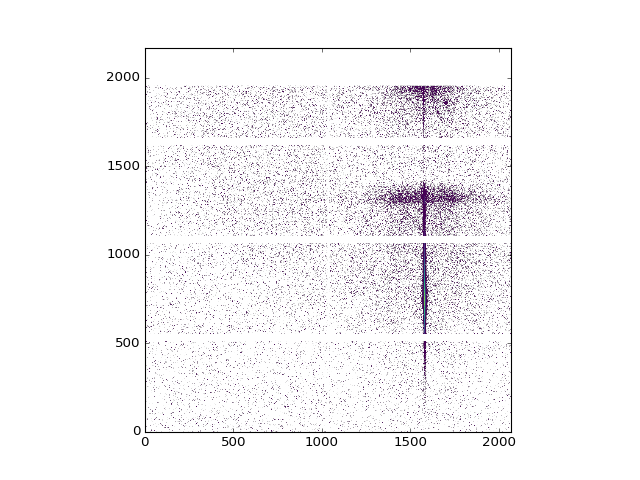

In [49]:
fig, ax = plt.subplots()
#new_mask = 
#im=ax.imshow(   (Mask) * avg_img,origin='lower' , 
#      norm= LogNorm( vmin=0.001, vmax=30 ), cmap='viridis')
#im = ax.imshow((mask)*avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
im = ax.imshow((mask)*avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=1, vmax=1000 ) )
plt.show()

## Combine the hand-drawn/polygon mask and the pixel mask and hot pixel mask

<IPython.core.display.Javascript object>


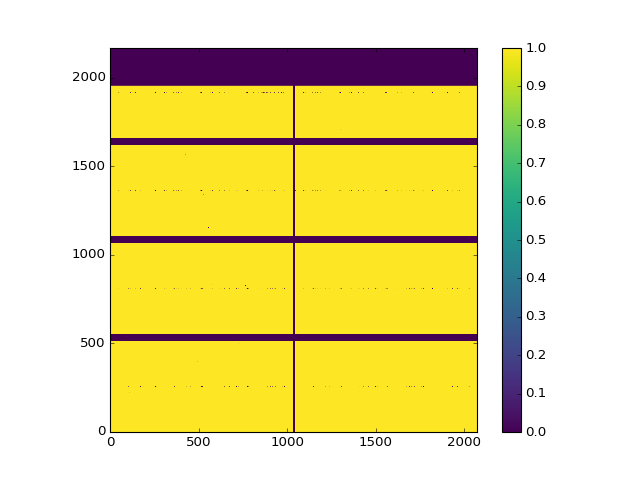

In [50]:
#mask = np.array ( ~new_mask* ~plgon_mask * md['pixel_mask']*mask_rh, dtype = bool )

fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Save the combined mask to use in further data analysis

In [52]:
np.save(  path +   uid +"_mask", mask)

In [ ]:
#np.save(  path +   'July3' +"_mask", mask)

In [53]:
#np.save(  path +   'Octo_11' +"_mask", mask)